# CISC489 Final Project:
**<h3>Modeling Traffic Flow with Physics-Informed Neural Networks (PINNs) Using the LWR Equation<h3>**

## Imports and problem setup

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# traffic fundamental diagram: v(ρ) = 1 - ρ (dimensionless)
def flux(rho):
    return rho * (1 - rho)

# domain boundaries
x_min, x_max = 0.0, 1.0
t_min, t_max = 0.0, 1.0

# number of training points
N_f = 20_000   # collocation (interior) points
N_b = 200      # boundary points
N_i = 200      # initial points


Using device: cpu


## Define the PINN model

In [12]:
class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.activation = nn.Tanh()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-2):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.layers.append(nn.Linear(layers[-2], layers[-1]))

        # initialize weights
        for m in self.layers:
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x, t):
        X = torch.cat([x, t], dim=1)
        for layer in self.layers[:-1]:
            X = self.activation(layer(X))
        return self.layers[-1](X)


## PDE residual and loss functions


In [13]:
def pde_residual(model, x, t):
    # predict density
    rho = model(x, t)
    # gradients
    rho_t = torch.autograd.grad(rho, t, grad_outputs=torch.ones_like(rho),
                                retain_graph=True, create_graph=True)[0]
    rho_x = torch.autograd.grad(rho, x, grad_outputs=torch.ones_like(rho),
                                retain_graph=True, create_graph=True)[0]
    # flux derivative
    f = flux(rho)
    f_x = torch.autograd.grad(f, x, grad_outputs=torch.ones_like(f),
                              retain_graph=True, create_graph=True)[0]
    # PDE: rho_t + f_x = 0
    return rho_t + f_x


## Generate training data

In [14]:
# interior collocation points
x_f = torch.rand(N_f,1)*(x_max-x_min) + x_min
t_f = torch.rand(N_f,1)*(t_max-t_min) + t_min

# initial condition: a Gaussian pulse
x_i = torch.linspace(x_min, x_max, N_i).view(-1,1)
t_i = torch.zeros_like(x_i)
rho_i = torch.exp(-100*(x_i-0.5)**2)  # pulse centered at 0.5

# left/right boundary: zero-gradient (Neumann)
t_b = torch.linspace(t_min, t_max, N_b).view(-1,1)
x_b0 = torch.full_like(t_b, x_min)
x_b1 = torch.full_like(t_b, x_max)


## Move data to device and set requires_grad


In [15]:
x_f = x_f.to(device).requires_grad_(True)
t_f = t_f.to(device).requires_grad_(True)

x_i, t_i, rho_i = x_i.to(device), t_i.to(device), rho_i.to(device)

# For boundary points, enable gradient tracking on x so we can do ∂ρ/∂x
x_b0 = x_b0.to(device).requires_grad_(True)
x_b1 = x_b1.to(device).requires_grad_(True)
t_b  = t_b.to(device)  # we only need grad w.r.t. x, t_b can remain False


## Instantiate model and optimizer


In [ ]:
layers = [2, 50, 50, 50, 1]
model = PINN(layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


## Training loop

Starting training...
Epoch 0/5000 — Loss: 3.758e-02 (PDE 1.1e-02, IC 2.6e-02, BC 5.9e-04)
Epoch 500/5000 — Loss: 3.700e-02 (PDE 1.1e-02, IC 2.6e-02, BC 2.4e-04)
Epoch 1000/5000 — Loss: 3.702e-02 (PDE 1.1e-02, IC 2.6e-02, BC 2.4e-04)
Epoch 1500/5000 — Loss: 3.680e-02 (PDE 1.1e-02, IC 2.6e-02, BC 8.8e-06)
Epoch 2000/5000 — Loss: 3.706e-02 (PDE 1.1e-02, IC 2.6e-02, BC 1.1e-04)
Epoch 2500/5000 — Loss: 3.708e-02 (PDE 1.1e-02, IC 2.6e-02, BC 3.5e-04)
Epoch 3000/5000 — Loss: 3.700e-02 (PDE 1.1e-02, IC 2.6e-02, BC 1.9e-04)
Epoch 3500/5000 — Loss: 3.683e-02 (PDE 1.1e-02, IC 2.6e-02, BC 4.6e-05)
Epoch 4000/5000 — Loss: 3.689e-02 (PDE 1.1e-02, IC 2.6e-02, BC 8.1e-05)
Epoch 4500/5000 — Loss: 3.737e-02 (PDE 1.1e-02, IC 2.6e-02, BC 4.5e-04)
Training finished.


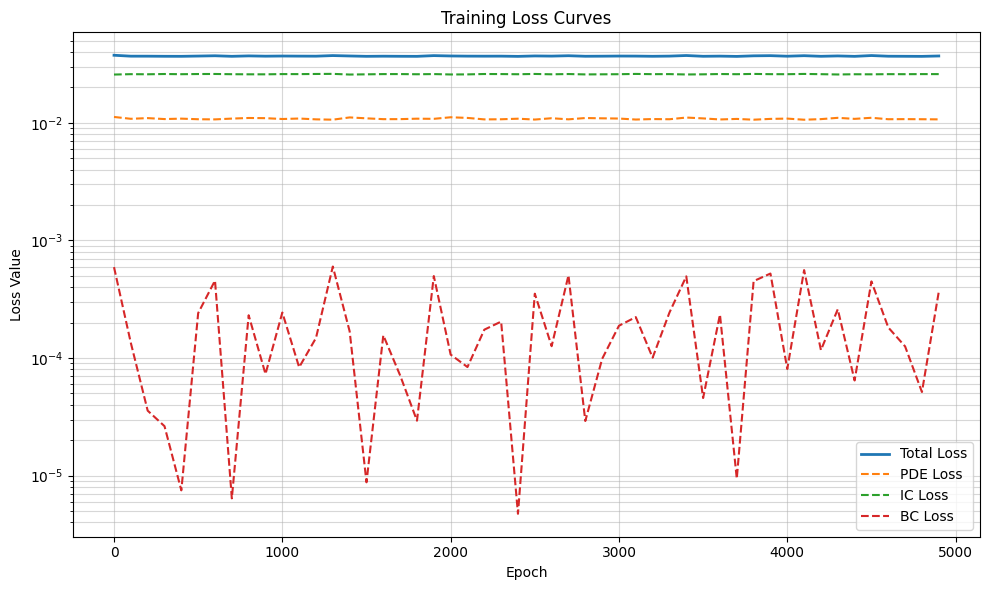


--- Conservation Analysis ---
SciPy not found, using simple trapezoidal rule with PyTorch.
At t = 0.00, total integrated density = 0.177312
SciPy not found, using simple trapezoidal rule with PyTorch.
At t = 0.10, total integrated density = 0.185810
SciPy not found, using simple trapezoidal rule with PyTorch.
At t = 0.20, total integrated density = 0.194392
SciPy not found, using simple trapezoidal rule with PyTorch.
At t = 0.30, total integrated density = 0.201632
SciPy not found, using simple trapezoidal rule with PyTorch.
At t = 0.40, total integrated density = 0.204893
SciPy not found, using simple trapezoidal rule with PyTorch.
At t = 0.50, total integrated density = 0.203608
SciPy not found, using simple trapezoidal rule with PyTorch.
At t = 0.60, total integrated density = 0.198854
SciPy not found, using simple trapezoidal rule with PyTorch.
At t = 0.70, total integrated density = 0.191616
SciPy not found, using simple trapezoidal rule with PyTorch.
At t = 0.80, total integrate

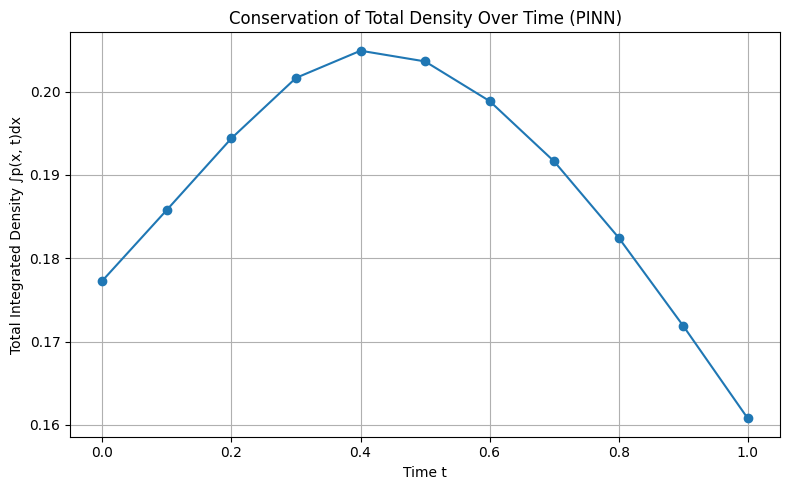

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
# from scipy.integrate import simps # Optional: for more accurate integration

# --- Your existing setup code ---
# device definition
# flux function
# domain boundaries (x_min, x_max, t_min, t_max)
# N_f, N_b, N_i
# PINN class definition
# pde_residual function
# Data generation (x_f, t_f, x_i, t_i, rho_i, x_b0, x_b1, t_b)
# Moving data to device and setting requires_grad
# Model instantiation (layers, model = PINN(layers).to(device))
# Optimizer instantiation (optimizer = optim.Adam(...))
# ---------------------------------

# --- Lists to store loss values FOR PLOTTING LOSS CURVES (Good Practice) ---
epoch_log_list = []
loss_total_log_list = []
loss_pde_log_list = []
loss_ic_log_list = []
loss_bc_log_list = []

# --- MAIN TRAINING LOOP (Your Provided Code) ---
print("Starting training...")
num_epochs = 5000
for epoch in range(num_epochs):
    model.train() # Good practice to set model to train mode
    optimizer.zero_grad()

    # PDE loss
    r = pde_residual(model, x_f, t_f)
    loss_pde = torch.mean(r**2)

    # IC loss
    rho_pred_i = model(x_i, t_i) # x_i, t_i should be on the correct device
    loss_ic = torch.mean((rho_pred_i - rho_i)**2) # rho_i should be on the correct device

    # BC loss: enforce zero derivative at x=0 and x=1
    rho_b0 = model(x_b0, t_b) # x_b0, t_b should be on the correct device
    rho_b1 = model(x_b1, t_b) # x_b1, t_b should be on the correct device
    rho_x_b0 = torch.autograd.grad(rho_b0, x_b0,
                                   grad_outputs=torch.ones_like(rho_b0),
                                   retain_graph=True, create_graph=True)[0]
    rho_x_b1 = torch.autograd.grad(rho_b1, x_b1,
                                   grad_outputs=torch.ones_like(rho_b1),
                                   retain_graph=True, create_graph=True)[0]

    loss_bc = torch.mean(rho_x_b0**2) + torch.mean(rho_x_b1**2)

    # total loss
    loss = loss_pde + loss_ic + loss_bc
    loss.backward()
    optimizer.step()

    # Log losses for plotting loss curves
    if epoch % 100 == 0: # Log more frequently for smoother loss curves
        epoch_log_list.append(epoch)
        loss_total_log_list.append(loss.item())
        loss_pde_log_list.append(loss_pde.item())
        loss_ic_log_list.append(loss_ic.item())
        loss_bc_log_list.append(loss_bc.item())
        if epoch % 500 == 0: # Print less frequently to reduce clutter
             print(f"Epoch {epoch}/{num_epochs} — Loss: {loss.item():.3e} (PDE {loss_pde.item():.1e}, IC {loss_ic.item():.1e}, BC {loss_bc.item():.1e})")

print("Training finished.")

# --- Plotting Training Loss Curves (AFTER TRAINING) ---
plt.figure(figsize=(10, 6))
plt.plot(epoch_log_list, loss_total_log_list, label='Total Loss', linewidth=2)
plt.plot(epoch_log_list, loss_pde_log_list, label='PDE Loss', linestyle='--')
plt.plot(epoch_log_list, loss_ic_log_list, label='IC Loss', linestyle='--')
plt.plot(epoch_log_list, loss_bc_log_list, label='BC Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.yscale('log')
plt.title('Training Loss Curves')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()
plt.savefig('training_loss_curves.png') # Save the figure
plt.show()


# ==============================================================================
# --- CODE FOR CONSERVATION ANALYSIS AND PERCENTAGE CALCULATION (ADD THIS BLOCK) ---
# ==============================================================================
print("\n--- Conservation Analysis ---")
model.eval() # Set model to evaluation mode for inference

# Define x points for integration (choose a reasonable number for accuracy)
# Ensure x_min, x_max are defined (they should be from your setup)
num_points_x_conservation = 200 # Or more, e.g., 500
x_conservation = torch.linspace(x_min, x_max, num_points_x_conservation).view(-1,1).to(device)
x_conservation_np = x_conservation.cpu().numpy().flatten() # For SciPy or dx calculation

# Define time points at which to check conservation
time_points_for_conservation = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# You can use more time points for a finer analysis:
# time_points_for_conservation = np.linspace(t_min, t_max, 21).tolist() 

total_densities_at_times = []

for t_val in time_points_for_conservation:
    t_val_tensor = torch.full_like(x_conservation, t_val).to(device)
    with torch.no_grad(): # Disable gradient calculations for inference
        # Get density prediction from the PINN
        # .squeeze() removes extra dimensions if model outputs (N,1)
        # .cpu().numpy() moves to CPU and converts to NumPy array for integration with SciPy or simple sum
        p_at_t = model(x_conservation, t_val_tensor).squeeze().cpu().numpy()

    # Numerical integration
    # Option 1: Using SciPy's Simpson's rule (generally more accurate)
    try:
        from scipy.integrate import simps
        integral_at_t = simps(p_at_t, x_conservation_np)
    except ImportError:
        print("SciPy not found, using simple trapezoidal rule with PyTorch.")
        # Option 2: Using PyTorch's trapz (if you keep tensors on device for a bit longer)
        # Re-do prediction to keep on device if using torch.trapz
        with torch.no_grad():
            p_at_t_torch = model(x_conservation, t_val_tensor).squeeze()
        integral_at_t = torch.trapz(y=p_at_t_torch, x=x_conservation.squeeze()).item()
    # Option 3: Simple Riemann sum (less accurate but fallback)
    # dx = (x_max - x_min) / (num_points_x_conservation - 1)
    # integral_at_t = np.sum(p_at_t * dx)
    
    total_densities_at_times.append(integral_at_t)
    print(f"At t = {t_val:.2f}, total integrated density = {integral_at_t:.6f}")

# --- Calculate and print percentage deviation ---
print("\n--- Calculating Conservation Error Percentage ---")
if not total_densities_at_times or len(total_densities_at_times) < 1: # Need at least one value
    print("Insufficient data to calculate conservation error percentage.")
    max_percentage_deviation_from_initial = float('nan') 
else:
    initial_total_density = total_densities_at_times[0] 
    print(f"Initial Total Integrated Density (at t={time_points_for_conservation[0]:.2f}): {initial_total_density:.6f}")

    max_absolute_deviation = 0.0

    for i in range(len(total_densities_at_times)): # Iterate all, including initial
        current_total_density = total_densities_at_times[i]
        absolute_difference_from_initial = abs(current_total_density - initial_total_density)
        
        if absolute_difference_from_initial > max_absolute_deviation:
            max_absolute_deviation = absolute_difference_from_initial
            
        # Optional: Print deviation at each step for inspection (if desired)
        if i > 0 and abs(initial_total_density) > 1e-9 :
            percentage_deviation = (absolute_difference_from_initial / abs(initial_total_density)) * 100
            # print(f"At t={time_points_for_conservation[i]:.2f}: Integrated Density = {current_total_density:.6f}, Abs Diff = {absolute_difference_from_initial:.6f}, % Dev = {percentage_deviation:.4f}%")

    if abs(initial_total_density) > 1e-9:
        max_percentage_deviation_from_initial = (max_absolute_deviation / abs(initial_total_density)) * 100
    else:
        max_percentage_deviation_from_initial = float('inf') if max_absolute_deviation > 1e-9 else 0.0
        
    print(f"\nMaximum Absolute Deviation from Initial Total Density: {max_absolute_deviation:.6f}")
    print(f"Maximum Percentage Deviation from Initial Total Density: {max_percentage_deviation_from_initial:.4f}%")

# --- Plot Conservation Over Time (AFTER TRAINING & CALCULATION) ---
plt.figure(figsize=(8,5))
plt.plot(time_points_for_conservation, total_densities_at_times, marker='o', linestyle='-')
plt.xlabel("Time t")
plt.ylabel("Total Integrated Density ∫p(x, t)dx")
plt.title("Conservation of Total Density Over Time (PINN)")
plt.grid(True)
# Optional: Zoom y-axis to better see small variations
# if max_absolute_deviation > 0 and abs(initial_total_density) > 1e-9:
#    plot_margin = max_absolute_deviation * 1.5 
#    if initial_total_density - plot_margin < initial_total_density + plot_margin : # ensure sensible limits
#       plt.ylim([initial_total_density - plot_margin, initial_total_density + plot_margin])
plt.tight_layout()
plt.savefig('conservation_over_time.png')
plt.show()

# --- VISUALIZE DENSITY PROFILES (Heatmap and/or Line plots - AFTER TRAINING) ---
# ... Your existing code for this, ensure model.eval() is called before it ...

## Visualize results at a few time slices


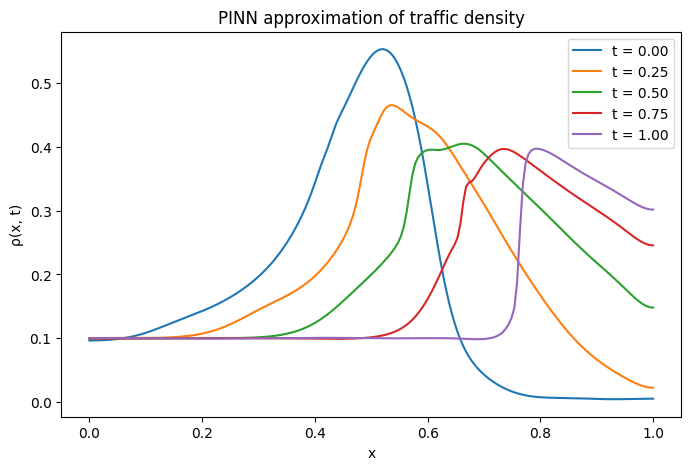

In [42]:
model.eval()
x_plot = torch.linspace(x_min, x_max, 200).view(-1,1).to(device)
plt.figure(figsize=(8,5))
for t_val in [0.0, 0.25, 0.5, 0.75, 1.0]:
    t_plot = torch.full_like(x_plot, t_val)
    rho_plot = model(x_plot, t_plot).detach().cpu().numpy()
    plt.plot(x_plot.cpu(), rho_plot, label=f"t = {t_val:.2f}")
plt.xlabel("x")
plt.ylabel("ρ(x, t)")
plt.title("PINN approximation of traffic density")
plt.legend()
plt.show()


## Saving Results for Use in Visualization

In [ ]:
import numpy as np
import pandas as pd
import json

# dump JSON for React
out = {
    "x": x_vals.numpy().flatten().tolist(),
    "t": t_vals.numpy().flatten().tolist(),
    "rho": rho.tolist()
}
with open("density.json","w") as f:
    json.dump(out, f)


NameError: name 'x_vals' is not defined

In [ ]:
# ...existing code...
# After training and before saving results

# Create a grid for x and t
x_vals = torch.linspace(x_min, x_max, 200)
t_vals = torch.linspace(t_min, t_max, 5)  # e.g., 5 time slices

# Evaluate model on the grid
X, T = torch.meshgrid(x_vals, t_vals, indexing='ij')
X_flat = X.reshape(-1,1).to(device)
T_flat = T.reshape(-1,1).to(device)
with torch.no_grad():
    rho = model(X_flat, T_flat).cpu().numpy().reshape(X.shape)

# Save as JSON
out = {
    "x": x_vals.numpy().flatten().tolist(),
    "t": t_vals.numpy().flatten().tolist(),
    "rho": rho.tolist()
}
with open("density.json","w") as f:
    json.dump(out, f)